## Advanced Lane Finding Project

The goals / steps of this project are the following:

* ~~Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.~~
* ~~Apply a distortion correction to raw images.~~
* ~~Use color transforms, gradients, etc., to create a thresholded binary image.~~
* ~~Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##  Camera calibration using chessboard images

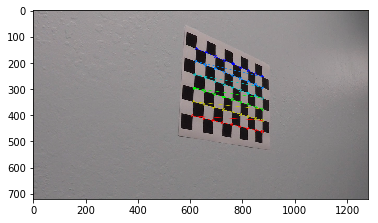

In [2]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# print(images)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)


# calculate ret, mtx, dist, rvecs,tvecs 
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)




## undistorting all callibration images

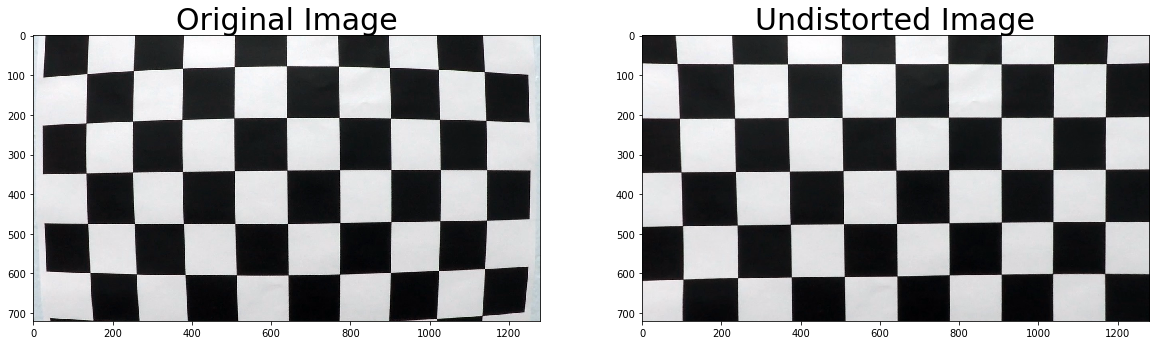

In [3]:
for fname in images:
    #print(['calibration_result/'+fname[11::]])
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('calibration_result/'+fname[11::],dst)



# Visualize undistortion example
img = cv2.imread(images[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Color transforms and gradients

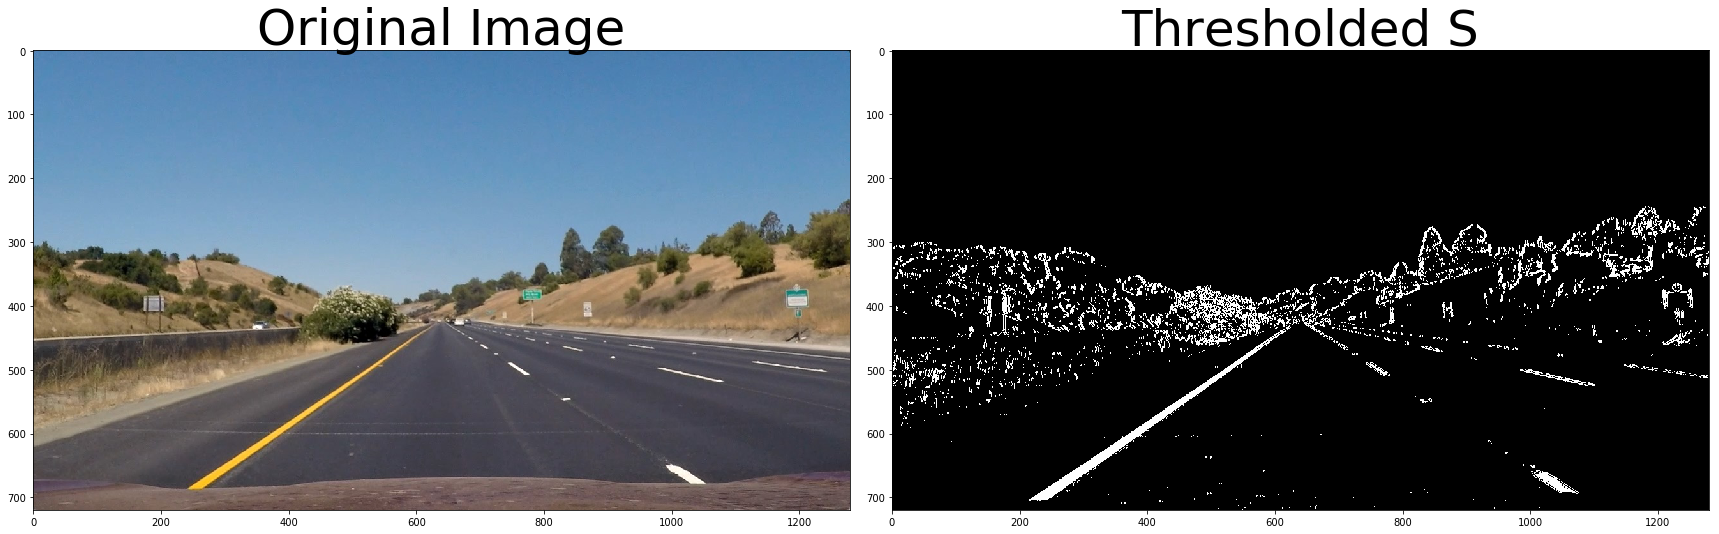

In [31]:
def col_trans_grad(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    

input_image = mpimg.imread('test_images/straight_lines1.jpg') 


undistorted_image = cv2.undistort(input_image, mtx, dist, None, mtx)
col_trans_image   = col_trans_grad(undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(input_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(col_trans_image, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)

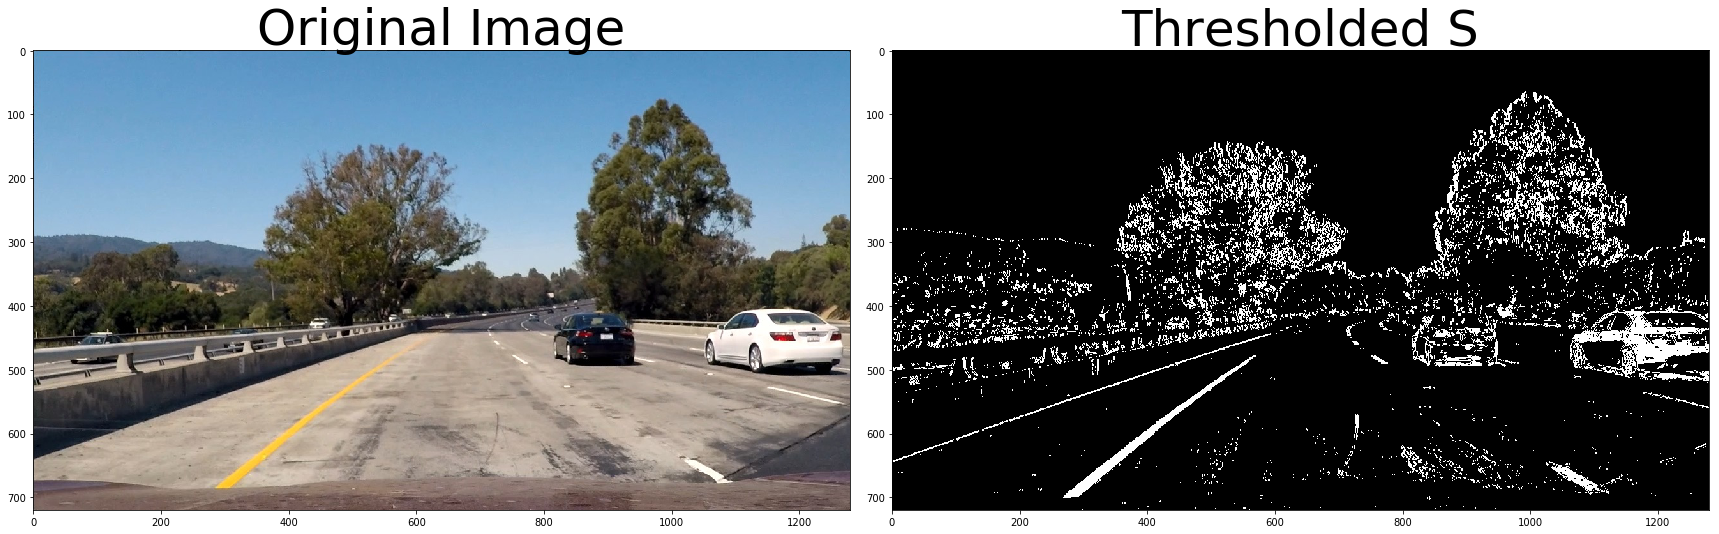

In [32]:
input_image1 = mpimg.imread('test_images/test1.jpg') 


undistorted_image = cv2.undistort(input_image1, mtx, dist, None, mtx)
col_trans_image1   = col_trans_grad(undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(input_image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(col_trans_image1, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)

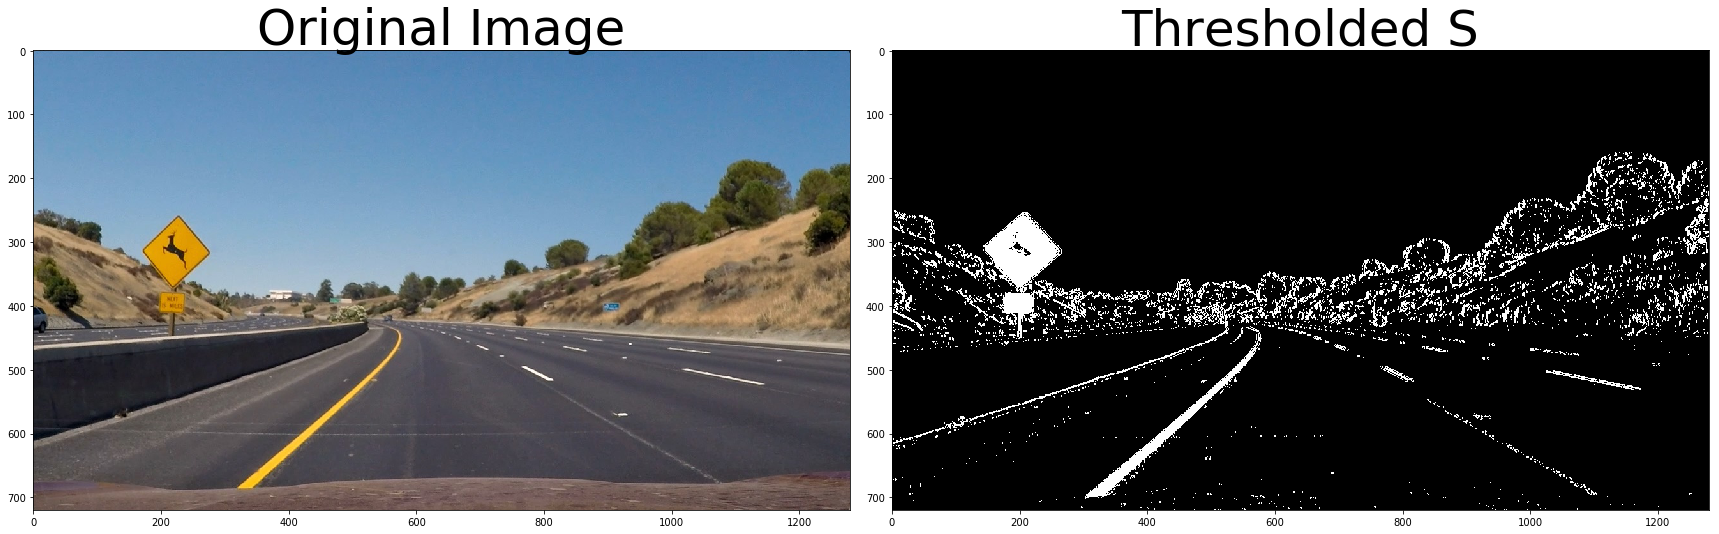

In [33]:
input_image2 = mpimg.imread('test_images/test2.jpg') 


undistorted_image = cv2.undistort(input_image2, mtx, dist, None, mtx)
col_trans_image2   = col_trans_grad(undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(input_image2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(col_trans_image2, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)

## perspective transform

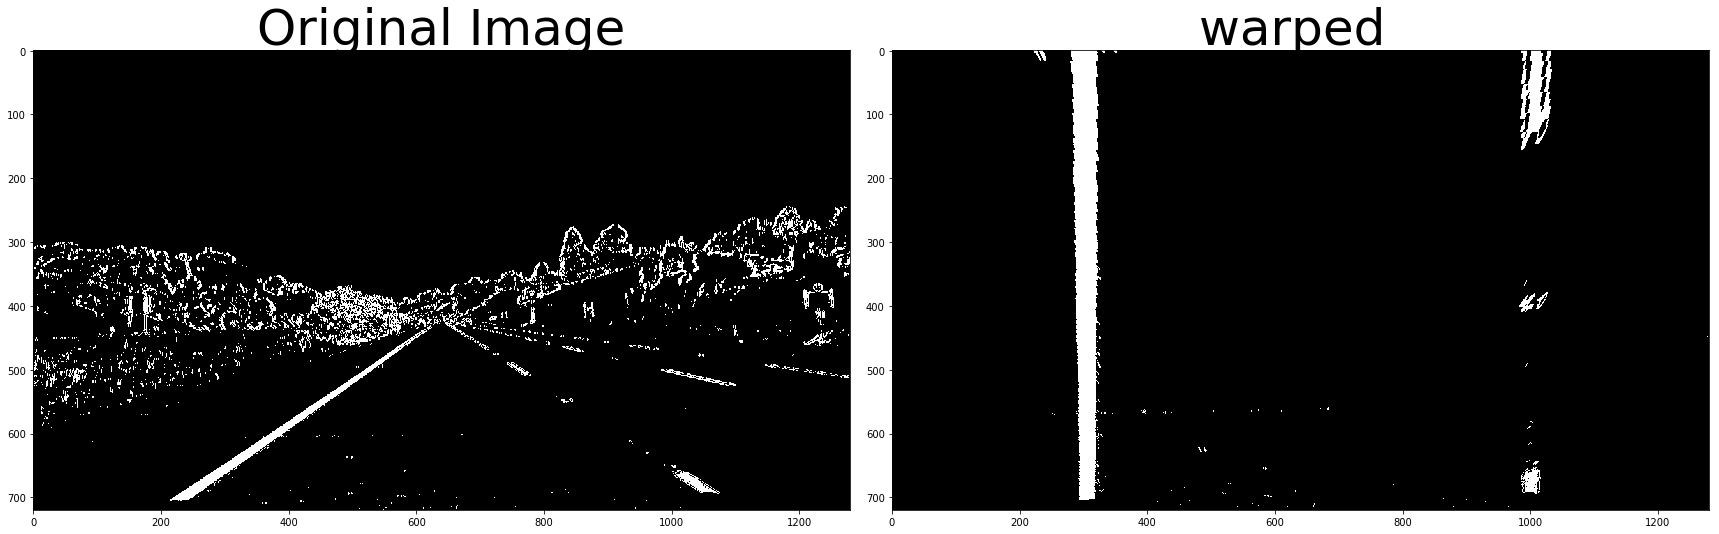

In [50]:
src_points = np.float32([[265, 680], [1048, 680], 
                [594, 453], [687, 453]])


centre= (265+1048)/2
offset = 200
dst_points = np.float32([[centre-offset, 680], [centre+offset, 680], 
                  [centre-offset, 680-10*offset], [centre+offset, 680-10*offset]])


src_points = np.float32([[265, 680], [1048, 680], 
                [622, 435], [658, 435]])

centre= (265+1048)/2
offset = 700
dst_points = np.float32([[centre-offset/2, 680], [centre+offset/2, 680], 
                  [centre-offset/2, 680-8*offset], [centre+offset/2, 680-8*offset]])


M = cv2.getPerspectiveTransform(src_points, dst_points)
inv_M = cv2.getPerspectiveTransform(dst_points, src_points)

# e) use cv2.warpPerspective() to warp your image to a top-down view
img_size = (img.shape[1], img.shape[0])
warped_image = cv2.warpPerspective(col_trans_image, M, img_size, flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(col_trans_image, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('warped ', fontsize=50)

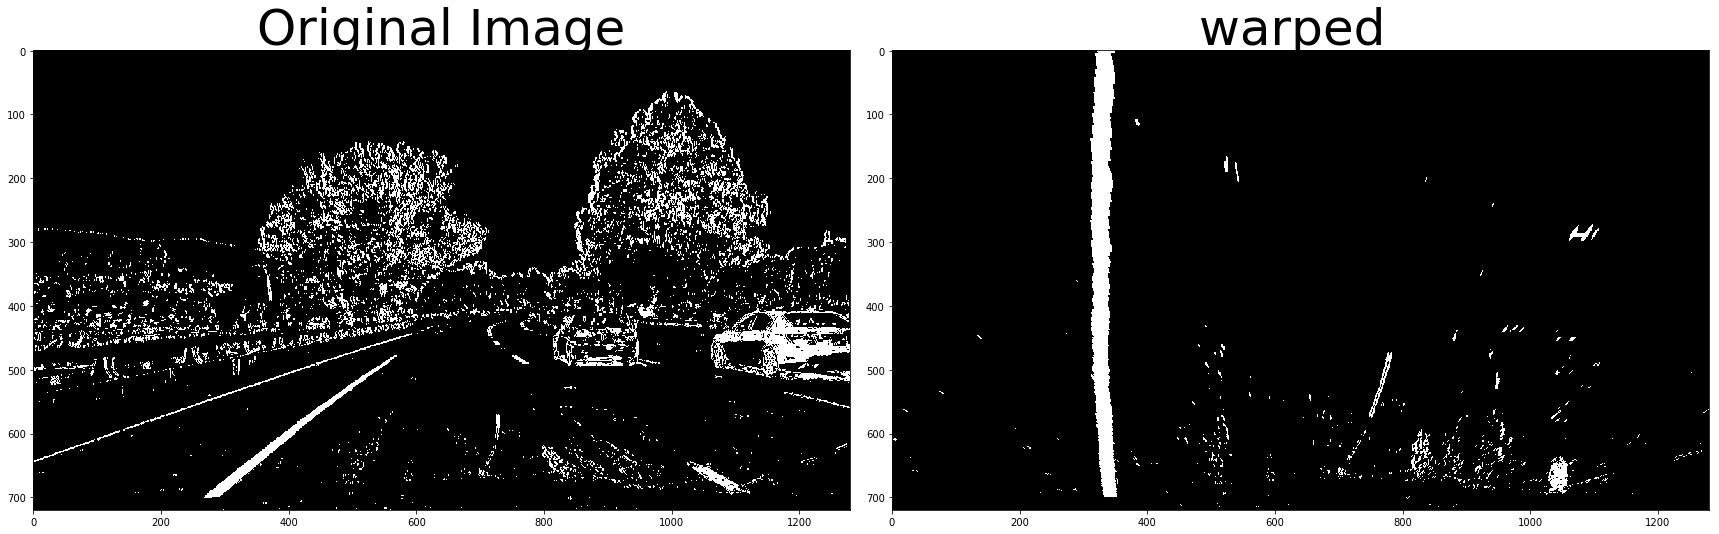

In [51]:
warped_image1 = cv2.warpPerspective(col_trans_image1, M, img_size, flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(col_trans_image1, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image1, cmap='gray')
ax2.set_title('warped ', fontsize=50)

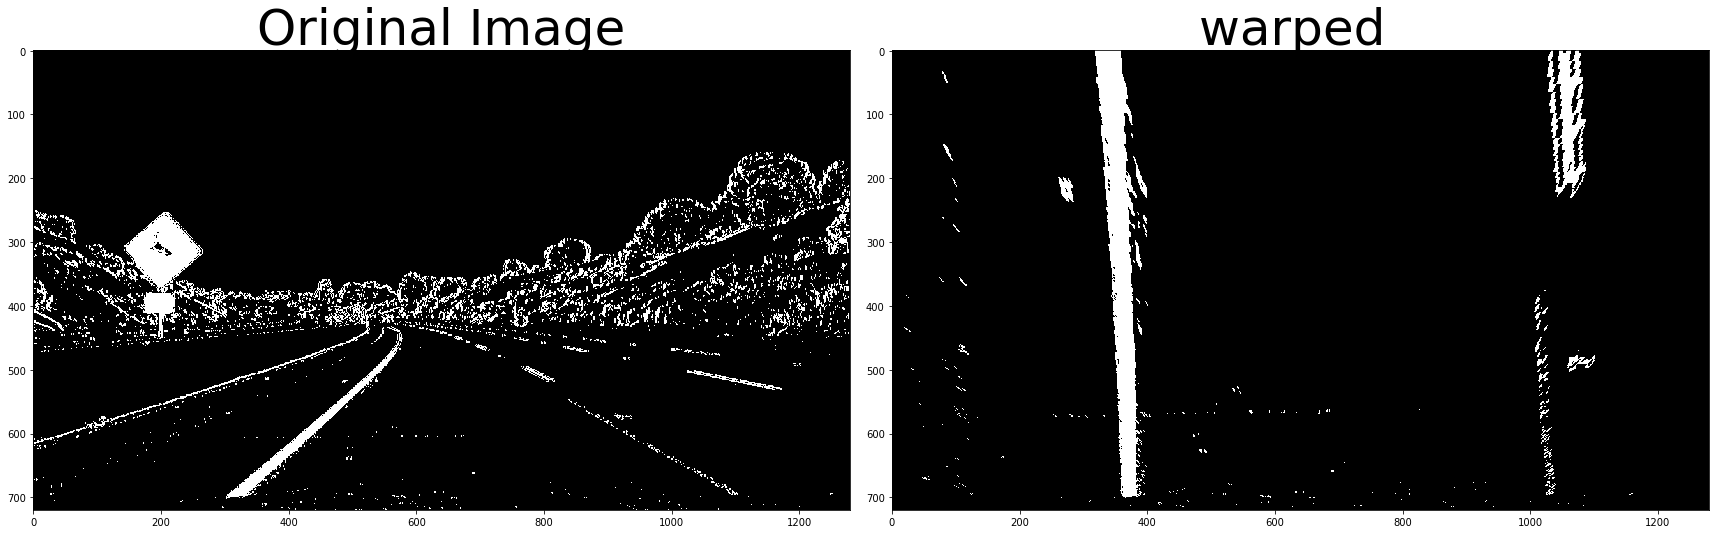

In [52]:
warped_image2 = cv2.warpPerspective(col_trans_image2, M, img_size, flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(col_trans_image2, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image2, cmap='gray')
ax2.set_title('warped ', fontsize=50)

## Sliding Windows


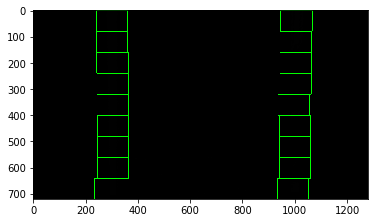

In [53]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img




def fit_poly(binary_warped_shape,leftx, lefty, rightx, righty):

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_shape[0]-1, binary_warped_shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, ploty





leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


plt.imshow(out_img)



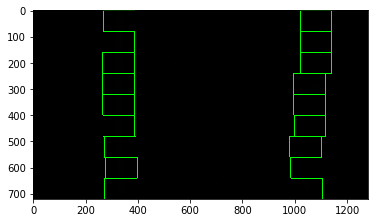

In [54]:
leftx, lefty, rightx, righty, out_img1 = find_lane_pixels(warped_image1)

plt.imshow(out_img1)

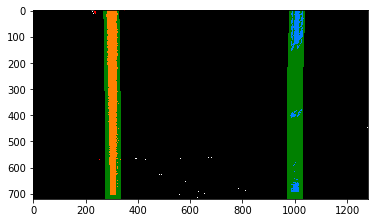

In [101]:
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 70

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox>(left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy+left_fit[2]-margin)) &
                        (nonzerox<(left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy+left_fit[2]+margin))).nonzero()[0]
    right_lane_inds = ((nonzerox>(right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy+right_fit[2]-margin)) &
                        (nonzerox<(right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy+right_fit[2]+margin))).nonzero()[0]
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx)==0:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
      
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    margin = 30
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.5, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,left_fit,right_fit


leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
out_img,left_fit,right_fit = search_around_poly(warped_image,left_fit,right_fit)

plt.imshow(out_img)


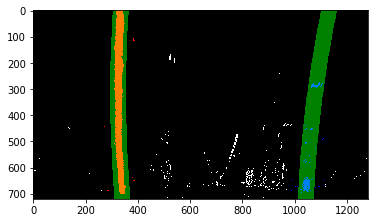

In [102]:
leftx, lefty, rightx, righty, out_img1 = find_lane_pixels(warped_image1)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
out_img1,left_fit,right_fit = search_around_poly(warped_image1,left_fit,right_fit)

plt.imshow(out_img1)

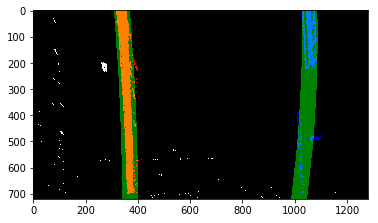

In [103]:
leftx, lefty, rightx, righty, out_img2 = find_lane_pixels(warped_image2)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
out_img2,left_fit,right_fit = search_around_poly(warped_image2,left_fit,right_fit)

plt.imshow(out_img2)

168194.240791
3486.38018777
0.074848019758


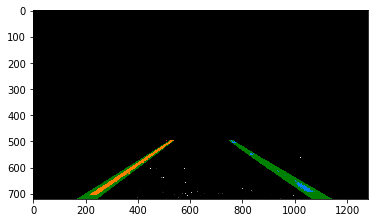

In [104]:

def fit_polynomial_accutal(binary_warped):
    # Find our lane pixels first
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    y_eval = np.max(lefty)*ym_per_pix
    
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/np.absolute(2*left_fit[0])
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/np.absolute(2*right_fit[0])
    
    
    left_fitx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fitx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    vehicle_pos = (left_fitx+right_fitx)/2-binary_warped.shape[1]/2*xm_per_pix
        
    return left_curverad, right_curverad, vehicle_pos




left_curverad, right_curverad,vehicle_pos = fit_polynomial_accutal(warped_image)

print(left_curverad)
print(right_curverad)
print(vehicle_pos)


un_warped = cv2.warpPerspective(out_img, inv_M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(un_warped)




1701.21355326
778.483981282
0.277339414474


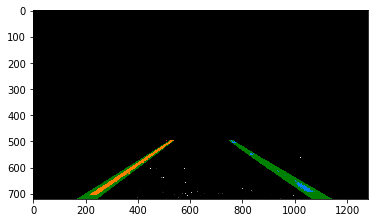

In [105]:
left_curverad, right_curverad,vehicle_pos = fit_polynomial_accutal(warped_image1)

print(left_curverad)
print(right_curverad)
print(vehicle_pos)


un_warped1 = cv2.warpPerspective(out_img1, inv_M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(un_warped)

3227.1422863
3065.45882898
0.287755903794


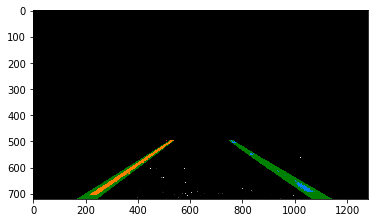

In [106]:
left_curverad, right_curverad,vehicle_pos = fit_polynomial_accutal(warped_image2)

print(left_curverad)
print(right_curverad)
print(vehicle_pos)


un_warped2 = cv2.warpPerspective(out_img2, inv_M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(un_warped)

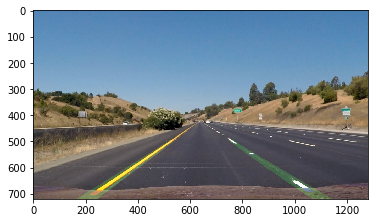

In [107]:
result2 = cv2.addWeighted(input_image, 1, un_warped, 0.3, 0)
plt.imshow(result2)


In [108]:

counter =0

def process_image(input_image):
    undistorted_image = cv2.undistort(input_image, mtx, dist, None, mtx)
    col_trans_image   = col_trans_grad(undistorted_image)
    
    #M = cv2.getPerspectiveTransform(src_points, dst_points)
    #inv_M = cv2.getPerspectiveTransform(dst_points, src_points)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    #img_size = (img.shape[1], img.shape[0])
    
    warped_image = cv2.warpPerspective(col_trans_image, M, img_size, flags=cv2.INTER_LINEAR)
    
    global counter
    
    
    global left_fit,right_fit
    if counter <1:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    
    out_img,left_fit,right_fit = search_around_poly(warped_image,left_fit,right_fit)
    
    left_curverad, right_curverad,vehicle_pos = fit_polynomial_accutal(warped_image)
    un_warped = cv2.warpPerspective(out_img, inv_M, img_size, flags=cv2.INTER_LINEAR)
    result2 = cv2.addWeighted(input_image, 1, un_warped, 0.3, 0)
    
    text = 'left=' + str(left_curverad) + ' right=' + str(right_curverad) + ' pos=' + str(vehicle_pos)
    
    font                   = cv2.FONT_HERSHEY_COMPLEX
    bottomLeftCornerOfText = (300,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineThickness          = 1

    cv2.putText(result2,text,bottomLeftCornerOfText,font,fontScale,fontColor,lineThickness)
    counter = counter +1
    return result2

    

In [109]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2


white_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:31,  8.34it/s]

  0%|          | 2/1261 [00:00<02:34,  8.15it/s]

  0%|          | 4/1261 [00:00<02:22,  8.80it/s]

  0%|          | 6/1261 [00:00<02:07,  9.81it/s]

  1%|          | 8/1261 [00:00<01:58, 10.62it/s]

  1%|          | 9/1261 [00:00<02:10,  9.62it/s]

  1%|          | 11/1261 [00:01<01:58, 10.59it/s]

  1%|          | 13/1261 [00:01<01:56, 10.73it/s]

  1%|          | 15/1261 [00:01<01:49, 11.40it/s]

  1%|▏         | 17/1261 [00:01<01:47, 11.55it/s]

  2%|▏         | 19/1261 [00:01<01:39, 12.52it/s]

  2%|▏         | 21/1261 [00:01<01:38, 12.60it/s]

  2%|▏         | 23/1261 [00:01<01:37, 12.76it/s]

  2%|▏         | 25/1261 [00:02<01:36, 12.87it/s]

  2%|▏         | 27/1261 [00:02<01:33, 13.16it/s]

  2%|▏         | 29/1261 [00:02<01:35, 12.87it/s]

  2%|▏         | 31/1261 [00:02<01:34, 12.97it/s]

  3%|▎         | 33/1261 [00:02<01:36, 12.78it/s]

  3%|▎         | 35/1261 [00:02<01:36, 12.72

 22%|██▏       | 281/1261 [00:22<01:22, 11.92it/s]

 22%|██▏       | 283/1261 [00:22<01:23, 11.70it/s]

 23%|██▎       | 285/1261 [00:23<01:27, 11.18it/s]

 23%|██▎       | 287/1261 [00:23<01:30, 10.74it/s]

 23%|██▎       | 289/1261 [00:23<01:33, 10.39it/s]

 23%|██▎       | 291/1261 [00:23<01:28, 11.00it/s]

 23%|██▎       | 293/1261 [00:23<01:25, 11.33it/s]

 23%|██▎       | 295/1261 [00:23<01:24, 11.43it/s]

 24%|██▎       | 297/1261 [00:24<01:20, 11.92it/s]

 24%|██▎       | 299/1261 [00:24<01:19, 12.12it/s]

 24%|██▍       | 301/1261 [00:24<01:21, 11.74it/s]

 24%|██▍       | 303/1261 [00:24<01:20, 11.96it/s]

 24%|██▍       | 305/1261 [00:24<01:21, 11.77it/s]

 24%|██▍       | 307/1261 [00:24<01:20, 11.84it/s]

 25%|██▍       | 309/1261 [00:25<01:18, 12.10it/s]

 25%|██▍       | 311/1261 [00:25<01:17, 12.21it/s]

 25%|██▍       | 313/1261 [00:25<01:15, 12.51it/s]

 25%|██▍       | 315/1261 [00:25<01:21, 11.58it/s]

 25%|██▌       | 317/1261 [00:25<01:20, 11.73it/s]

 25%|██▌    

 44%|████▍     | 553/1261 [00:46<01:01, 11.49it/s]

 44%|████▍     | 555/1261 [00:46<01:01, 11.56it/s]

 44%|████▍     | 557/1261 [00:46<01:00, 11.71it/s]

 44%|████▍     | 559/1261 [00:46<00:59, 11.78it/s]

 44%|████▍     | 561/1261 [00:47<00:58, 11.97it/s]

 45%|████▍     | 563/1261 [00:47<00:58, 11.92it/s]

 45%|████▍     | 565/1261 [00:47<01:00, 11.54it/s]

 45%|████▍     | 567/1261 [00:47<00:59, 11.74it/s]

 45%|████▌     | 569/1261 [00:47<00:59, 11.68it/s]

 45%|████▌     | 571/1261 [00:47<01:00, 11.46it/s]

 45%|████▌     | 573/1261 [00:48<01:03, 10.83it/s]

 46%|████▌     | 575/1261 [00:48<01:06, 10.34it/s]

 46%|████▌     | 577/1261 [00:48<01:08, 10.03it/s]

 46%|████▌     | 579/1261 [00:48<01:09,  9.83it/s]

 46%|████▌     | 580/1261 [00:48<01:09,  9.84it/s]

 46%|████▌     | 581/1261 [00:49<01:09,  9.78it/s]

 46%|████▌     | 582/1261 [00:49<01:12,  9.32it/s]

 46%|████▋     | 584/1261 [00:49<01:08,  9.85it/s]

 46%|████▋     | 586/1261 [00:49<01:04, 10.47it/s]

 47%|████▋  

 65%|██████▌   | 825/1261 [01:09<00:30, 14.08it/s]

 66%|██████▌   | 827/1261 [01:09<00:30, 14.03it/s]

 66%|██████▌   | 829/1261 [01:09<00:30, 14.04it/s]

 66%|██████▌   | 831/1261 [01:09<00:32, 13.04it/s]

 66%|██████▌   | 833/1261 [01:10<00:33, 12.93it/s]

 66%|██████▌   | 835/1261 [01:10<00:31, 13.40it/s]

 66%|██████▋   | 837/1261 [01:10<00:31, 13.48it/s]

 67%|██████▋   | 839/1261 [01:10<00:32, 13.04it/s]

 67%|██████▋   | 841/1261 [01:10<00:31, 13.39it/s]

 67%|██████▋   | 843/1261 [01:10<00:31, 13.09it/s]

 67%|██████▋   | 845/1261 [01:10<00:30, 13.54it/s]

 67%|██████▋   | 847/1261 [01:11<00:30, 13.50it/s]

 67%|██████▋   | 849/1261 [01:11<00:30, 13.57it/s]

 67%|██████▋   | 851/1261 [01:11<00:30, 13.34it/s]

 68%|██████▊   | 853/1261 [01:11<00:30, 13.53it/s]

 68%|██████▊   | 855/1261 [01:11<00:29, 13.68it/s]

 68%|██████▊   | 857/1261 [01:11<00:29, 13.48it/s]

 68%|██████▊   | 859/1261 [01:11<00:29, 13.66it/s]

 68%|██████▊   | 861/1261 [01:12<00:28, 13.97it/s]

 68%|██████▊

 86%|████████▋ | 1089/1261 [01:32<00:15, 11.37it/s]

 87%|████████▋ | 1091/1261 [01:32<00:14, 11.77it/s]

 87%|████████▋ | 1093/1261 [01:32<00:14, 11.68it/s]

 87%|████████▋ | 1095/1261 [01:32<00:13, 11.97it/s]

 87%|████████▋ | 1097/1261 [01:32<00:14, 11.61it/s]

 87%|████████▋ | 1099/1261 [01:32<00:13, 11.89it/s]

 87%|████████▋ | 1101/1261 [01:32<00:13, 12.14it/s]

 87%|████████▋ | 1103/1261 [01:33<00:13, 12.14it/s]

 88%|████████▊ | 1105/1261 [01:33<00:13, 11.92it/s]

 88%|████████▊ | 1107/1261 [01:33<00:12, 12.34it/s]

 88%|████████▊ | 1109/1261 [01:33<00:12, 12.40it/s]

 88%|████████▊ | 1111/1261 [01:33<00:12, 12.47it/s]

 88%|████████▊ | 1113/1261 [01:33<00:11, 12.63it/s]

 88%|████████▊ | 1115/1261 [01:34<00:11, 12.51it/s]

 89%|████████▊ | 1117/1261 [01:34<00:11, 12.33it/s]

 89%|████████▊ | 1119/1261 [01:34<00:11, 12.61it/s]

 89%|████████▉ | 1121/1261 [01:34<00:11, 12.60it/s]

 89%|████████▉ | 1123/1261 [01:34<00:10, 12.65it/s]

 89%|████████▉ | 1125/1261 [01:34<00:10, 12.63

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 36s, sys: 16.6 s, total: 3min 53s
Wall time: 1min 46s


In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))